In [1]:
# 先来个300k下的文件练练手
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append(r'C:\Users\zhang\1_jupyter_code\1_Functions')
from read_file import read_one_frame_xyz as r_xyz
from cal_ppp_dis import cal_ppp_distance as cal_dis


In [2]:
center_element = 'Si'
nei_element = 'O'

In [4]:
g_data_path = r'C:\Users\zhang\Desktop\md\las_growth\19k_md_1108\xyz\0glass_300k_out.xyz'
g_data = r_xyz(g_data_path,0)

g_max_x,g_max_y,g_max_z = 0,0,0
list_nb = []
list_o = []
for i in g_data:
    g_max_x,g_max_y,g_max_z = max(g_max_x,i[1]),max(g_max_y,i[2]),max(g_max_z,i[3])
    if i[0] == center_element:
        list_nb.append(i)
    if i[0] == nei_element:
        list_o.append(i)
g_box_size = [g_max_x,g_max_y,g_max_z]
print('box: ',g_box_size)

box:  [82.884012, 54.127368, 11.2583]


In [5]:
from scipy.spatial import cKDTree
def calculate_distance(coord1, coord2, lattice_vectors):
    # 考虑周期性边界条件的距离计算
    displacement = coord2 - coord1
    displacement -= np.round(displacement.dot(np.linalg.inv(lattice_vectors))).dot(lattice_vectors)
    print(displacement)
    distance = np.linalg.norm(displacement)
    return distance
def calculate_distance(coord1, coord2, lattice_vectors):
    # 考虑周期性边界条件的距离计算
    displacement = coord2 - coord1
    displacement -= np.round(displacement.dot(np.linalg.inv(lattice_vectors))).dot(lattice_vectors)
    distance = np.linalg.norm(displacement)
    return distance

def calculate_nearest_oxygen_atoms(coords, atom_types, box_size, num_nearest=10):
    # 获取Nb原子的索引
    nb_indices = np.where(atom_types == center_element)[0]
    # 获取O原子的索引
    o_indices = np.where(atom_types == 'O')[0]

    # 获取Nb和O原子的坐标
    nb_coords = coords[nb_indices]
    o_coords = coords[o_indices]

    # 构建模拟盒子的晶格向量
    lattice_vectors = np.diag(box_size)

    # 使用KD树构建O原子的索引
    o_tree = cKDTree(o_coords)

    # 存储结果的列表
    result_list = []

    # 为每个Nb原子找到最近的O原子
    for nb_coord in nb_coords:
        _, indices = o_tree.query(nb_coord, k=num_nearest)
        distances = []
        for o_index in indices:
            distance = calculate_distance(nb_coord, o_coords[o_index], lattice_vectors)
            distances.append(distance)
        for o_index, distance in zip(indices, distances):
            result = [nb_coord, distance, o_coords[o_index]]
            result_list.append(result)

    return result_list

# 示例用法
g_xyz_file = g_data_path

# 读取XYZ文件
def read_xyz_file(file_path):
    with open(file_path, 'r') as file:
        num_atoms = int(file.readline())
        file.readline()
        atom_types = []
        coords = []
        for _ in range(num_atoms):
            line = file.readline().split()
            atom_types.append(line[0])
            coords.append([float(line[1]), float(line[2]), float(line[3])])
    return np.array(coords), np.array(atom_types)

coords, atom_types = read_xyz_file(g_xyz_file)

# 计算每个Nb原子附近的最近的10个O原子的结果列表
g_result_list = calculate_nearest_oxygen_atoms(coords, atom_types, g_box_size, num_nearest=10)

In [6]:
g_result_list[0]

[array([22.077412,  7.567488,  6.98814 ]),
 1.58812669463113,
 array([21.657312,  8.463798,  5.74625 ])]

In [7]:
g_list_neighber = []
for i in range(0,len(g_result_list),10):
    list_dis_temp = []
    for j in range(10):
        list_dis_temp.append(g_result_list[i+j][1])
    g_list_neighber.append(list_dis_temp)
g_list_neighber = np.array(g_list_neighber).reshape(-1,10)

In [8]:
import numpy as np

def calculate_column_mean_and_std(data):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    return means, stds


# 计算每一列的均值和标准差
g_means, g_stds = calculate_column_mean_and_std(g_list_neighber)

# 将结果存储在列表中
g_list_mean = []
for mean, std in zip(g_means, g_stds):
    g_list_mean.append((mean, std))

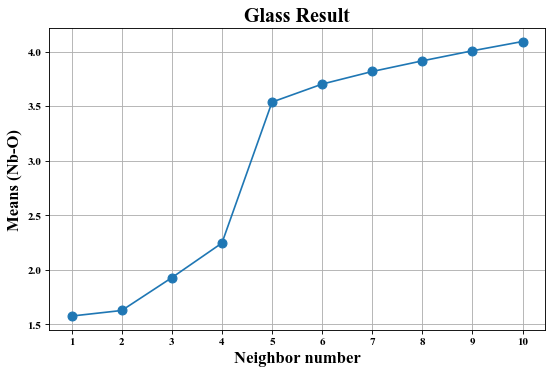

In [9]:

# 设置图的大小
plt.figure(figsize=(8, 5), dpi=80)


# 设置字体样式
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


# 绘制图表
plt.plot(range(1, 11), g_means,'o-', markersize=8)

# 设置坐标轴字体大小
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# 设置 x 轴间隔为 1
plt.xticks(range(1, 11))
# 玻璃还是晶体
plt.title('Glass Result', fontsize=18,weight='bold')

plt.xlabel('Neighbor number', fontsize=15,weight='bold')
plt.ylabel('Means (Nb-O)', fontsize=15,weight='bold')

plt.grid(True)
plt.show()

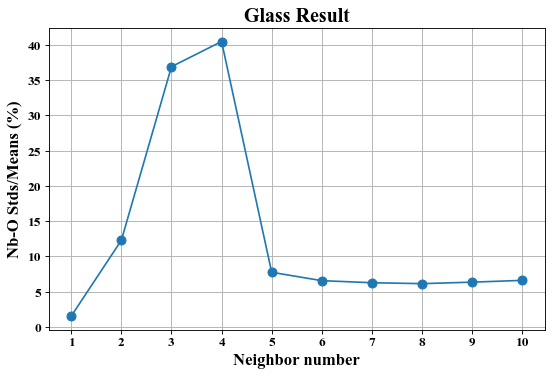

In [12]:
# 设置图的大小
plt.figure(figsize=(8, 5), dpi=80)


# 设置字体样式
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


# 绘制图表
plt.plot(range(1, 11), g_stds/g_means*100,'o-', markersize=8)

# 设置坐标轴字体大小
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# 设置 x 轴间隔为 1
plt.xticks(range(1, 11))

plt.title('Glass Result', fontsize=18,weight='bold')

plt.xlabel('Neighbor number', fontsize=15,weight='bold')
plt.ylabel('Nb-O Stds/Means (%)', fontsize=15,weight='bold')

plt.grid(True)
plt.show()

# 晶体

In [13]:
c_data_path = r'C:\Users\zhang\Desktop\md\las_growth\19k_md_1108\xyz\60cry_300k_out.xyz'
c_data = r_xyz(c_data_path,0)

c_max_x,c_max_y,c_max_z = 0,0,0
list_nb = []
list_o = []
for i in c_data:
    c_max_x,c_max_y,c_max_z = max(c_max_x,i[1]),max(c_max_y,i[2]),max(c_max_z,i[3])
    if i[0] == center_element:
        list_nb.append(i)
    if i[0] == 'O':
        list_o.append(i)
c_box_size = [c_max_x,c_max_y,c_max_z]
print('box: ',c_box_size)

box:  [83.820074, 54.767182, 11.39167]


In [15]:
from scipy.spatial import cKDTree
def calculate_distance(coord1, coord2, lattice_vectors):
    # 考虑周期性边界条件的距离计算
    displacement = coord2 - coord1
    displacement -= np.round(displacement.dot(np.linalg.inv(lattice_vectors))).dot(lattice_vectors)
    print(displacement)
    distance = np.linalg.norm(displacement)
    return distance
def calculate_distance(coord1, coord2, lattice_vectors):
    # 考虑周期性边界条件的距离计算
    displacement = coord2 - coord1
    displacement -= np.round(displacement.dot(np.linalg.inv(lattice_vectors))).dot(lattice_vectors)
    distance = np.linalg.norm(displacement)
    return distance

def calculate_nearest_oxygen_atoms(coords, atom_types, box_size, num_nearest=10):
    # 获取Nb原子的索引
    nb_indices = np.where(atom_types == center_element)[0]
    # 获取O原子的索引
    o_indices = np.where(atom_types == 'O')[0]

    # 获取Nb和O原子的坐标
    nb_coords = coords[nb_indices]
    o_coords = coords[o_indices]

    # 构建模拟盒子的晶格向量
    lattice_vectors = np.diag(box_size)

    # 使用KD树构建O原子的索引
    o_tree = cKDTree(o_coords)

    # 存储结果的列表
    result_list = []

    # 为每个Nb原子找到最近的O原子
    for nb_coord in nb_coords:
        _, indices = o_tree.query(nb_coord, k=num_nearest)
        distances = []
        for o_index in indices:
            distance = calculate_distance(nb_coord, o_coords[o_index], lattice_vectors)
            distances.append(distance)
        for o_index, distance in zip(indices, distances):
            result = [nb_coord, distance, o_coords[o_index]]
            result_list.append(result)

    return result_list

# 示例用法
c_xyz_file = c_data_path

# 读取XYZ文件
def read_xyz_file(file_path):
    with open(file_path, 'r') as file:
        num_atoms = int(file.readline())
        file.readline()
        atom_types = []
        coords = []
        for _ in range(num_atoms):
            line = file.readline().split()
            atom_types.append(line[0])
            coords.append([float(line[1]), float(line[2]), float(line[3])])
    return np.array(coords), np.array(atom_types)

coords, atom_types = read_xyz_file(c_xyz_file)

# 计算每个Nb原子附近的最近的10个O原子的结果列表
c_result_list = calculate_nearest_oxygen_atoms(coords, atom_types, c_box_size, num_nearest=10)

In [16]:
c_list_neighber = []
for i in range(0,len(c_result_list),10):
    list_dis_temp = []
    for j in range(10):
        list_dis_temp.append(c_result_list[i+j][1])
    c_list_neighber.append(list_dis_temp)
c_list_neighber = np.array(c_list_neighber).reshape(-1,10)

In [17]:
import numpy as np

def calculate_column_mean_and_std(data):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    return means, stds


# 计算每一列的均值和标准差
c_means, c_stds = calculate_column_mean_and_std(c_list_neighber)

# 将结果存储在列表中
c_list_mean = []
for mean, std in zip(c_means, c_stds):
    c_list_mean.append((mean, std))

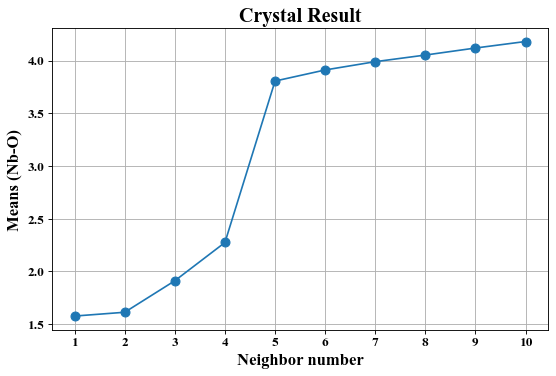

In [18]:

# 设置图的大小
plt.figure(figsize=(8, 5), dpi=80)


# 设置字体样式
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


# 绘制图表
plt.plot(range(1, 11), c_means,'o-', markersize=8)

# 设置坐标轴字体大小
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# 设置 x 轴间隔为 1
plt.xticks(range(1, 11))
# 玻璃还是晶体
plt.title('Crystal Result', fontsize=18,weight='bold')

plt.xlabel('Neighbor number', fontsize=15,weight='bold')
plt.ylabel('Means (Nb-O)', fontsize=15,weight='bold')

plt.grid(True)
plt.show()

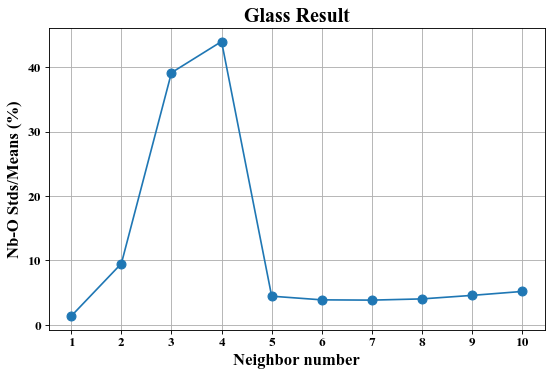

In [19]:
# 设置图的大小
plt.figure(figsize=(8, 5), dpi=80)


# 设置字体样式
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


# 绘制图表
plt.plot(range(1, 11), c_stds/c_means*100,'o-', markersize=8)

# 设置坐标轴字体大小
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# 设置 x 轴间隔为 1
plt.xticks(range(1, 11))

plt.title('Glass Result', fontsize=18,weight='bold')

plt.xlabel('Neighbor number', fontsize=15,weight='bold')
plt.ylabel('Nb-O Stds/Means (%)', fontsize=15,weight='bold')

plt.grid(True)
plt.show()

# 比较二者差异

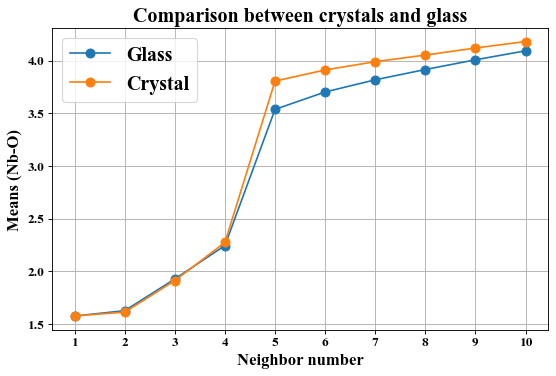

In [20]:

# 设置图的大小
plt.figure(figsize=(8, 5), dpi=80)


# 设置字体样式
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


# 绘制图表
plt.plot(range(1, 11), g_means,'o-', markersize=8, label='Glass')

# 绘制2
plt.plot(range(1, 11), c_means,'o-', markersize=8, label='Crystal')

# 设置坐标轴字体大小
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# 设置 x 轴间隔为 1
plt.xticks(range(1, 11))
# 玻璃还是晶体
plt.title('Comparison between crystals and glass', fontsize=18,weight='bold')
plt.xlabel('Neighbor number', fontsize=15,weight='bold')
plt.ylabel('Means (Nb-O)', fontsize=15,weight='bold')

# 获取图例对象
plt.legend(fontsize=18)


plt.grid(True)
plt.show()

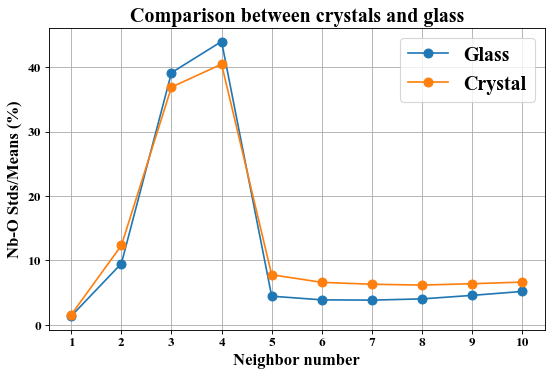

In [21]:

# 设置图的大小
plt.figure(figsize=(8, 5), dpi=80)


# 设置字体样式
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


# 绘制图表
plt.plot(range(1, 11), c_stds/c_means*100,'o-', markersize=8, label='Glass')

# 绘制2
plt.plot(range(1, 11), g_stds/g_means*100,'o-', markersize=8, label='Crystal')

# 设置坐标轴字体大小
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# 设置 x 轴间隔为 1
plt.xticks(range(1, 11))
plt.title('Comparison between crystals and glass', fontsize=18,weight='bold')
plt.xlabel('Neighbor number', fontsize=15,weight='bold')
plt.ylabel('Nb-O Stds/Means (%)', fontsize=15,weight='bold')
# 获取图例对象
plt.legend(fontsize=18)


plt.grid(True)
plt.show()

# 键角

In [22]:
def calculate_bond_angle(point1, point2, point3, boxsize):
    # 考虑周期性边界条件的点坐标修正
    point1, point2, point3, boxsize = np.array(point1),np.array(point2),np.array(point3),np.array(boxsize)
    boxsize_half = boxsize / 2
    point1_mod = np.mod(point1 + boxsize_half, boxsize) - boxsize_half
    point2_mod = np.mod(point2 + boxsize_half, boxsize) - boxsize_half
    point3_mod = np.mod(point3 + boxsize_half, boxsize) - boxsize_half
    
    # 考虑周期性边界条件的键角修正
    displacement1_mod = point2_mod - point1_mod
    displacement2_mod = point3_mod - point1_mod
    angle_mod = np.arccos(np.dot(displacement1_mod, displacement2_mod) / (np.linalg.norm(displacement1_mod) * np.linalg.norm(displacement2_mod)))
    
    return np.degrees(angle_mod)

# 示例数据
point1 = np.array([5, 8, 2])
point2 = np.array([1, 5, 1])
point3 = np.array([6, 2.5, 3])
boxsize = np.array([10, 10, 10])

# 计算键角
bond_angle = calculate_bond_angle(point1, point2, point3, boxsize)
print("键角：", bond_angle)

键角： 105.40794922149911


In [23]:
calculate_bond_angle(c_result_list[0][0], c_result_list[0][2], c_result_list[1][2], np.array(c_box_size))

120.2707955093689

In [24]:
list_bad = []
c_center_neighber = []
for i in range(0,len(c_result_list),10):
    list_neighber_temp = []
    # 每十个为一组数据
    for j in range(8):
        list_neighber_temp.append(c_result_list[i+j][2])
        # print(c_result_list[i+j])
    # 取出这个
    center_atom = c_result_list[i][0]
    # print('-------------------',center_atom)
    # 接下来就是计算键角  45个值临时存储在这
    list_temp_bad = []
    for i in range(8):
        for j in range(i+1,8):
            bad = calculate_bond_angle(center_atom,list_neighber_temp[i],list_neighber_temp[j],c_box_size)
            #print(center_atom,list_neighber_temp[i],list_neighber_temp[j],c_box_size)
            list_temp_bad.append(bad)
    list_bad.append(list_temp_bad)

In [25]:
len(list_neighber_temp)

8

In [26]:
np.array(list_bad).shape

(573, 28)

In [27]:
list_bad = np.array(list_bad).reshape(-1,28)

In [28]:
def calculate_column_mean_and_std(data):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    return means, stds


In [29]:
a = calculate_column_mean_and_std(list_bad)

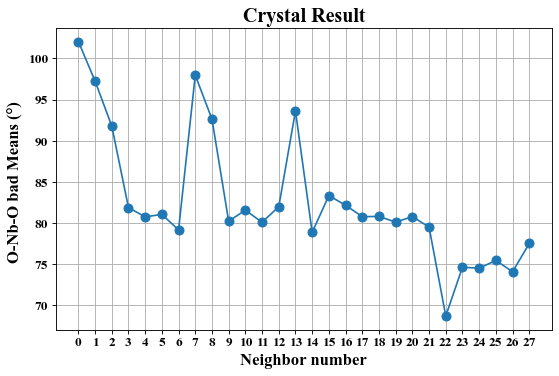

In [30]:
# 设置图的大小
plt.figure(figsize=(8, 5), dpi=80)


# 设置字体样式
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


# 绘制图表
plt.plot(range(len(a[0])),a[0],'o-', markersize=8)

# 设置坐标轴字体大小
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# 设置 x 轴间隔为 1
plt.xticks(range(len(a[0])))
# 玻璃还是晶体
plt.title('Crystal Result', fontsize=18,weight='bold')

plt.xlabel('Neighbor number', fontsize=15,weight='bold')
plt.ylabel('O-Nb-O bad Means (°) ', fontsize=15,weight='bold')

plt.grid(True)
plt.show()

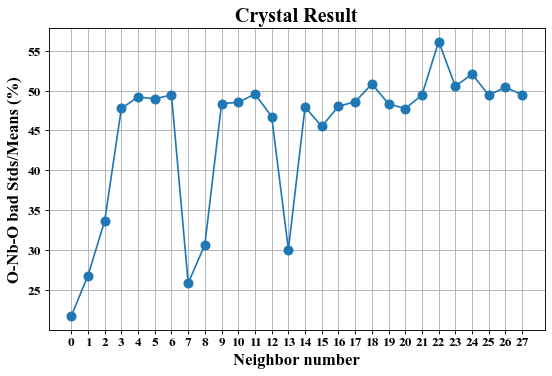

In [31]:
# 设置图的大小
plt.figure(figsize=(8, 5), dpi=80)


# 设置字体样式
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


# 绘制图表
plt.plot(range(len(a[1])),a[1]/a[0]*100,'o-', markersize=8)

# 设置坐标轴字体大小
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# 设置 x 轴间隔为 1
plt.xticks(range(len(a[1])))

plt.title('Crystal Result', fontsize=18,weight='bold')

plt.xlabel('Neighbor number', fontsize=15,weight='bold')
plt.ylabel('O-Nb-O bad Stds/Means (%)', fontsize=15,weight='bold')

plt.grid(True)
plt.show()

In [32]:
# 玻璃计算

In [33]:
g_box_size

[82.884012, 54.127368, 11.2583]

In [34]:
c_box_size

[83.820074, 54.767182, 11.39167]

In [35]:
list_bad = []
g_center_neighber = []
for i in range(0,len(g_result_list),10):
    list_neighber_temp = []
    # 每十个为一组数据
    for j in range(8):
        list_neighber_temp.append(g_result_list[i+j][2])
        # print(c_result_list[i+j])
    # 取出这个
    center_atom = g_result_list[i][0]
    # print('-------------------',center_atom)
    # 接下来就是计算键角  45个值临时存储在这
    list_temp_bad = []
    for i in range(8):
        for j in range(i+1,8):
            bad = calculate_bond_angle(center_atom,list_neighber_temp[i],list_neighber_temp[j],g_box_size)
            #print(center_atom,list_neighber_temp[i],list_neighber_temp[j],c_box_size)
            list_temp_bad.append(bad)
    list_bad.append(list_temp_bad)

In [36]:
calculate_bond_angle(center_atom,list_neighber_temp[i],list_neighber_temp[j],c_box_size)

C:\Users\zhang\AppData\Local\Temp\ipykernel_588\2164775618.py:12: RuntimeWarning: invalid value encountered in arccos
  angle_mod = np.arccos(np.dot(displacement1_mod, displacement2_mod) / (np.linalg.norm(displacement1_mod) * np.linalg.norm(displacement2_mod)))


nan

In [37]:
np.array(list_bad).shape

(573, 28)

In [38]:
list_bad = np.array(list_bad).reshape(-1,28)

In [39]:
b = calculate_column_mean_and_std(list_bad)

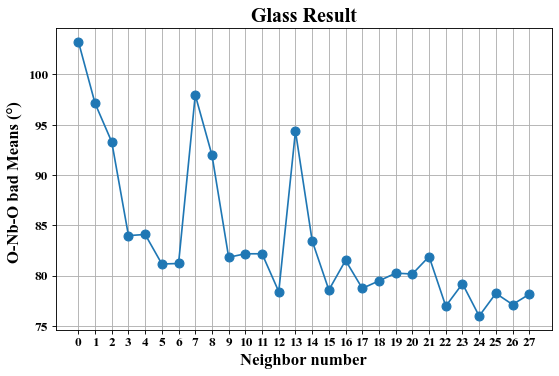

In [40]:
# 设置图的大小
plt.figure(figsize=(8, 5), dpi=80)


# 设置字体样式
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


# 绘制图表
plt.plot(range(len(b[0])),b[0],'o-', markersize=8)

# 设置坐标轴字体大小
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# 设置 x 轴间隔为 1
plt.xticks(range(len(a[0])))
# 玻璃还是晶体
plt.title('Glass Result', fontsize=18,weight='bold')

plt.xlabel('Neighbor number', fontsize=15,weight='bold')
plt.ylabel('O-Nb-O bad Means (°) ', fontsize=15,weight='bold')

plt.grid(True)
plt.show()

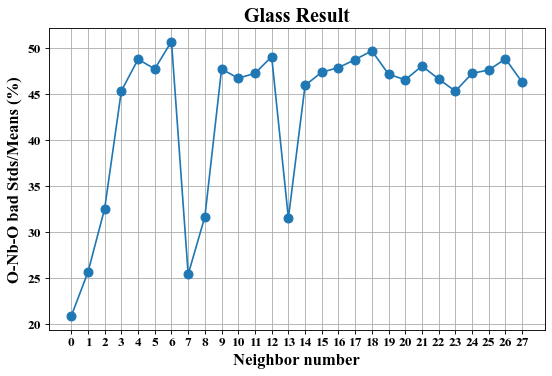

In [41]:
# 设置图的大小
plt.figure(figsize=(8, 5), dpi=80)


# 设置字体样式
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


# 绘制图表
plt.plot(range(len(b[1])),b[1]/b[0]*100,'o-', markersize=8)

# 设置坐标轴字体大小
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# 设置 x 轴间隔为 1
plt.xticks(range(len(a[1])))

plt.title('Glass Result', fontsize=18,weight='bold')

plt.xlabel('Neighbor number', fontsize=15,weight='bold')
plt.ylabel('O-Nb-O bad Stds/Means (%)', fontsize=15,weight='bold')

plt.grid(True)
plt.show()

In [42]:
# 对比

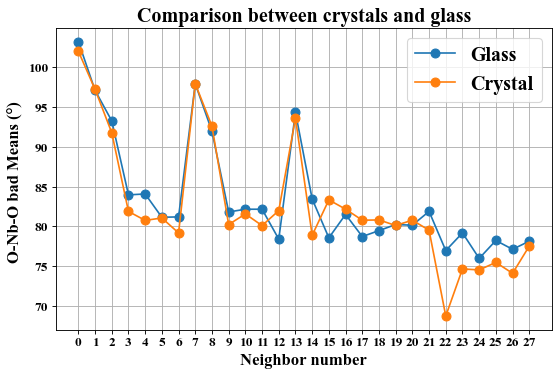

In [43]:

# 设置图的大小
plt.figure(figsize=(8, 5), dpi=80)


# 设置字体样式
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


# 绘制图表
plt.plot(range(len(b[1])),b[0],'o-', markersize=8, label='Glass')

plt.plot(range(len(a[1])),a[0],'o-', markersize=8, label='Crystal')


# 设置坐标轴字体大小
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# 设置 x 轴间隔为 1
plt.xticks(range(len(b[1])))
# 玻璃还是晶体
plt.title('Comparison between crystals and glass', fontsize=18,weight='bold')
plt.xlabel('Neighbor number', fontsize=15,weight='bold')
plt.ylabel('O-Nb-O bad Means (°) ', fontsize=15,weight='bold')

# 获取图例对象
plt.legend(fontsize=18)


plt.grid(True)
plt.show()

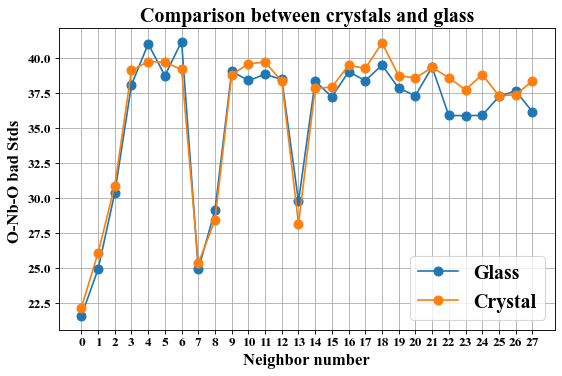

In [44]:

# 设置图的大小
plt.figure(figsize=(8, 5), dpi=80)


# 设置字体样式
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'


# 绘制图表
plt.plot(range(len(b[1])),b[1],'o-', markersize=8, label='Glass')

plt.plot(range(len(a[1])),a[1],'o-', markersize=8, label='Crystal')


# 设置坐标轴字体大小
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# 设置 x 轴间隔为 1
plt.xticks(range(len(b[1])))
# 玻璃还是晶体
plt.title('Comparison between crystals and glass', fontsize=18,weight='bold')
plt.xlabel('Neighbor number', fontsize=15,weight='bold')
plt.ylabel('O-Nb-O bad Stds ', fontsize=15,weight='bold')

# 获取图例对象
plt.legend(fontsize=18)


plt.grid(True)
plt.show()